In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import r2_score
import pickle
import time
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import sparse
import os.path
from scipy.interpolate import splrep, splev

In [3]:
import sys
sys.path.append('../.')

Implementation of AD algorithm:
- Step 1: find $M$ using soft-impute 
$$
M = \operatorname{argmin}_M \|M\|_* + \frac{1}{2\gamma}\|P_\Omega(M - X)\|_F^2
$$

- Step 2: Using $M$ to esitimate $p$ and $\alpha$ and obtain $\hat{p}, \hat{\alpha}$ (MLE estimator)

- Step 3: Using $M, \hat{p}, \hat{\alpha}$ to estimate $P(anomaly|X_{ij})$

- Step 4: sorting $P(anomaly|X_{ij})$ from largest to the smallest, and claim the anomaly in this order 

In [40]:
class Experiment(Experiment):

    def evaluate_ROC(self, posterior_anomaly, posterior_anomaly_est, Ω):
        '''
            sorting posterior_anomaly_est (1D array) from the largest to the smallest
            using the index to choose posterior_anomaly
            only entries in Ω is considered 

            Assuming the entries in posterior_anomaly_est is bounded by 1e20
        ''' 
        TΩ = np.reshape(Ω, -1)
        index = np.argsort(TΩ*(-posterior_anomaly_est) + (1-TΩ)*1e20)
        index = index[0:np.sum(Ω)]
        sorted_anomaly = posterior_anomaly[index]

        TPR = np.cumsum(sorted_anomaly) / np.sum(sorted_anomaly)
        FPR = np.cumsum(1-sorted_anomaly) / np.sum(1-sorted_anomaly)
        return FPR, TPR

    def ideal_ROC(self):
        posterior_anomaly = self.noise.posterior_anomaly_processing(self.M0, self.X, self.Ω)
        self.FPR_opt, self.TPR_opt = self.evaluate_ROC(posterior_anomaly, posterior_anomaly, self.Ω)
        self.posterior_anomaly = posterior_anomaly

    def cost_compute(self, t):
        return np.sum(self.Ω * (self.a * t + self.b)) / np.sum(self.Ω)

    def cost_compute_real_anomaly(self, t):
        A = self.cost11 * (t == 1) * (self.B == 1) + self.cost10 * (t == 1) * (self.B == 0) + self.cost01 * (t == 0) * (self.B == 1) + self.cost00 * (t == 0) * (self.B == 0)

        return np.sum(self.Ω * A) / np.sum(self.Ω) 

    def ideal_real_cost(self):
        t = (self.cost11 * (self.B == 1) + self.cost10 * (self.B == 0)) <= (self.cost01 * (self.B == 1) + self.cost00 * (self.B == 0))
        return self.cost_compute_real_anomaly(t)

    def cost_of_ignore(self):
        return self.cost_compute_real_anomaly(0)



    

    def PCA_with_M(self, M):

        self.posterior_anomaly_PCA = np.reshape(self.Ω*(np.abs(self.X-M)+1e-9), -1)
        #posterior_anomaly_PCA = np.reshape(Ω*(M0-X+100), -1)
        self.FPR_PCA_M0, self.TPR_PCA_M0 = self.evaluate_ROC(self.posterior_anomaly, self.posterior_anomaly_PCA, self.Ω)
        return self.FPR_PCA_M0, self.TPR_PCA_M0

Implementation of stable_pcp algorithm

 $$\operatorname{argmin}_{M,A} \|M\|_* + \lambda\|A\|_1 + \frac{\mu}{2}\|P_\Omega(M + A - X)\|_F^2$$

In [18]:
class Experiment(Experiment):

    

In [19]:
class Experiment(Experiment):
    

In [68]:
class Experiment(Experiment):

    def plot_ROC(self):
        print(count_AUC(self.FPR_opt, self.TPR_opt))
        print(count_AUC(self.FPR_AD, self.TPR_AD))
        plt.plot(self.FPR_opt, self.TPR_opt)
        plt.plot(self.FPR_AD, self.TPR_AD) 
        legend_list = [r'$\pi^{*}$', r'$\pi^{\mathrm{EW}}$']
        if (hasattr(self, 'FPR_PCA_M0')):
            print(count_AUC(self.FPR_PCA_M0, self.TPR_PCA_M0))
            plt.plot(self.FPR_PCA_M0, self.TPR_PCA_M0)
            legend_list.append('Stable PCP')
        if hasattr(self, 'FPR_PCA'):
            condition = (self.FPR_PCA <= self.TPR_PCA + 0.01)
            print(condition)
            print(count_AUC(self.FPR_PCA[condition], self.TPR_PCA[condition]))
            plt.plot(self.FPR_PCA[condition], self.TPR_PCA[condition])
            legend_list.append('Robust PCA')

        plt.legend(legend_list)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.savefig(self.data_type + '.eps')

        f = open('data.npy', 'wb')
        np.save(f, self.FPR_opt)
        np.save(f, self.TPR_opt)
        np.save(f, self.FPR_AD)
        np.save(f, self.TPR_AD)
        np.save(f, self.FPR_PCA_M0)
        np.save(f, self.TPR_PCA_M0)
        #plt.title('n = {}, r = {}, mean_value(M*)= {}, p = {}, alpha = {}\n MLE_p = {:.3f}, MLE_alpha = {:.3f}'.format(n, r, mean_value, p, alpha, p_est, alpha_est))
        plt.show()

    def generate_data_for_heat_map(self, l1 = 3, l2 = 3, force=False):

        if (not force):
            return
        #if (not force and os.path.isfile('heat_map_data.npy')):
        #    return
        mean_value_set = np.linspace(0.1, 10, l1)
        alpha_set = np.linspace(0.1, 1, l2)

        AUC_opt = np.zeros((len(mean_value_set), len(alpha_set)))
        AUC_AD = np.zeros((len(mean_value_set), len(alpha_set)))
        AUC_PCA = np.zeros((len(mean_value_set), len(alpha_set)))
        for (i, mean_value) in enumerate(mean_value_set):
            for (j, alpha) in enumerate(alpha_set):
                self.synthetic_data(self.n1, self.n2, self.r, mean_value, self.prob_observing)
                noise = Exponential_noise_model(p = 0.2, exp_rate = 1/alpha, p_range = (0.01, 0.5), one_over_exp_range=(0.01, 0.8))
                self.add_noise(noise)
                self.ideal_ROC()
                self.AD_algorithm(gamma = (self.n1/self.r)*0.5, r_constraint = self.r, debug=False, do_SVD = False)

                

                #self.PCA_with_M(self.M0)
                self.Robust_PCA(gamma = (self.n2/self.r*0.5), r_constraint=self.r)
                #self.PCA_with_M(self.M0+0.3*np.sqrt(self.M0)*np.random.normal(size=self.M0.shape))


                AUC_opt[i, j] = count_AUC(self.FPR_opt, self.TPR_opt)
                AUC_AD[i, j] = count_AUC(self.FPR_AD, self.TPR_AD)
                #AUC_PCA[i, j] = count_AUC(self.FPR_PCA_M0, self.TPR_PCA_M0)
                AUC_PCA[i, j] = count_AUC(self.FPR_PCA, self.TPR_PCA)


        f = open('heat_map_data.npy', 'wb')
        np.save(f, mean_value_set)
        np.save(f, alpha_set)
        np.save(f, AUC_opt)
        np.save(f, AUC_AD)
        np.save(f, AUC_PCA)

    def plot_heat_map(self, file_path = "", file_name = 'heat_map_data'):

        def plot_fig(data, title):
            sns.heatmap(data, annot=True, xticklabels=alpha_set, yticklabels=mean_value_set)
            plt.xlabel(r'$\alpha$')
            plt.ylabel(r'$\bar{M}^{*}$')
            plt.title(title)
            plt.savefig(file_path+title+'.eps')
            plt.show()  

        f = open(file_path+file_name, 'rb')
        mean_value_set = np.round(np.load(f), decimals = 2)
        alpha_set = np.round(np.load(f), decimals = 2)
        AUC_opt = np.load(f)
        AUC_AD = np.maximum(np.load(f), 0.5)
        AUC_PCA = np.maximum(np.load(f), 0.5)
        print(AUC_PCA[0,1])

        plot_fig(AUC_opt, 'AUC of ideal')
        plot_fig(AUC_AD/AUC_opt, 'AUC of EW over AUC of ideal')
        plot_fig(AUC_PCA/AUC_opt, 'AUC of PCA over AUC of ideal')
        plot_fig(AUC_AD/AUC_PCA, 'AUC of EW over AUC of PCA')

    def plot_heat_map(self, file_path = '', file_name = ''):

        def plot_fig(data, title):
            sns.heatmap(data, annot=True, xticklabels=alpha_set, yticklabels=mean_value_set)
            plt.xlabel(r'$\alpha$')
            plt.ylabel(r'$\bar{M}^{*}$')
            plt.title(title)
            plt.savefig(file_path+title+'.eps')
            plt.show()  

        f = open(file_path+file_name, 'rb')
        mean_value_set = np.round(np.load(f), decimals = 2)
        alpha_set = np.round(np.load(f), decimals = 2)
        AUC_opt = np.load(f)
        AUC_AD = np.maximum(np.load(f), 0.5)
        AUC_PCA = np.maximum(np.load(f), 0.5)
        print(AUC_PCA[0,1])

        plot_fig(AUC_opt, 'AUC of ideal')
        plot_fig(AUC_AD/AUC_opt, 'AUC of EW over AUC of ideal')
        plot_fig(AUC_PCA/AUC_opt, 'AUC of PCA over AUC of ideal')
        plot_fig(AUC_AD/AUC_PCA, 'AUC of EW over AUC of PCA')

    def generate_data_for_table_cost(self, file_path = "", file_name = "", num_exper=200, r_range = [1, 10],
                                    mean_value_range = [1, 10], p_o_range = [0.5, 1], p_a_range = [0, 0.3], alpha_range = [0, 1], force=True, AD_only=False):
        self.file_path = file_path
        self.file_name = file_name
        if (not force):
            return
        
        num_exper = 100
        
        c_opt = np.zeros(num_exper)
        c_AD = np.zeros(num_exper)
        c_PCA = np.zeros(num_exper)
        c_RMF = np.zeros(num_exper)
        c_DRMF = np.zeros(num_exper)

        parameters = []

        start = 0
        for T in range(start, num_exper):
            r = np.random.randint(r_range[0], high=r_range[1]+1)
            mean = np.random.uniform(mean_value_range[0], mean_value_range[1])
            p_o = np.random.uniform(p_o_range[0], p_o_range[1])
            p_a = np.random.uniform(p_a_range[0], p_a_range[1])
            alpha = np.random.uniform(alpha_range[0], alpha_range[1])

            self.synthetic_data(self.n1, self.n2, r, mean, p_o)
            noise = Exponential_noise_model(p = p_a, exp_rate = 1/alpha, p_range = (0.01, 0.5), one_over_exp_range=(0.01, 0.9))
            self.add_noise(noise)
            self.cost_generation()
            c_opt[T] = self.ideal_cost()

            if (AD_only):
                c_AD[T] = self.AD_algorithm(gamma = self.n1/r*0.5, r_constraint = self.r, debug=False, do_SVD = False, cost_only = True)
                x = []
                for rate in [0.1, 0.3, 0.5]:
                    x.append(self.DRMF(r, 0.3, cost_only=True))
                c_DRMF[T] = np.min(x)
            else:
                c_AD[T] = self.AD_algorithm(gamma = self.n1/r*0.5, r_constraint = self.r, debug=False, do_SVD = False, cost_only=True)
            
                x = []
                for rate in [0.1, 0.3, 0.5]:
                    x.append(self.DRMF(r, 0.3, cost_only=True))
                c_DRMF[T] = np.min(x)
                #c_PCA[T] = self.Robust_PCA(gamma = (self.n2/r*0.5/2), r_constraint=self.r, cost_only=True)

                #c_RMF[T] = self.Robust_PCA(gamma = (self.n2/r*0.5/2), r_constraint=self.r, up_M = np.max(self.M0)*12, up_A = np.max(self.M0)*12, cost_only=True)
    
            parameters.append((r, mean, p_o, p_a, alpha))

            print('In the step {}, c_opt is {}, c_AD is {}, c_PCA is {}, c_DRMF is {}, c_RMF is {}'.format(T, c_opt[T], c_AD[T], c_PCA[T], c_DRMF[T], c_RMF[T]))
            print('r is {}, mean is {}, p_o is {}, p_a is {}, alpha is {}'.format(r, mean, p_o, p_a, alpha))

            #print('Frobenious norm: AD {}, DRMF {}, RMF {}, PCA {}'.format(np.mean(F_AD[:T+1]), np.mean(F_DRMF[:T+1]), np.mean(F_RMF[:T+1]), np.mean(F_PCA[:T+1])))
            #print('max norm: AD {}, DRMF {}, RMF {}, PCA {}'.format(np.mean(max_AD[:T+1]), np.mean(max_DRMF[:T+1]), np.mean(max_RMF[:T+1]), np.mean(max_PCA[:T+1])))
            #print('AUC: AD {}, DRMF {}, RMF {}, PCA {}'.format(np.mean(AUC_AD[:T+1]), np.mean(AUC_DRMF[:T+1]), np.mean(AUC_RMF[:T+1]), np.mean(AUC_PCA[:T+1])))


            if (T % 10 == 0 or T == num_exper - 1):
                print('In the step {}, saving data...'.format(T))
                if not os.path.exists(file_path):
                    os.makedirs(file_path)
                f = open(file_path+file_name, 'wb')
                np.save(f, parameters)
                np.save(f, c_opt)
                np.save(f, c_AD)
                np.save(f, c_DRMF)
                np.save(f, c_RMF)
                np.save(f, c_PCA)
            
    def generate_data_for_table(self, file_path = "", file_name = "", num_exper=200, r_range = [1, 10], 
                                mean_value_range = [1, 10], p_o_range = [0.5, 1], p_a_range = [0, 0.3], alpha_range = [0, 1], force=True):
        self.file_path = file_path
        self.file_name = file_name
        if (not force):
            return
        
        num_exper = 100
        AUC_opt = np.zeros(num_exper)
        AUC_AD = np.zeros(num_exper)
        AUC_PCA = np.zeros(num_exper)
        AUC_RMF = np.zeros(num_exper)
        AUC_DRMF = np.zeros(num_exper)

        F_opt = np.zeros(num_exper)
        F_AD = np.zeros(num_exper)
        F_PCA = np.zeros(num_exper)
        F_RMF = np.zeros(num_exper)
        F_DRMF = np.zeros(num_exper)

        max_opt = np.zeros(num_exper)
        max_AD = np.zeros(num_exper)
        max_PCA = np.zeros(num_exper)
        max_RMF = np.zeros(num_exper)
        max_DRMF = np.zeros(num_exper)

        parameters = []

        start = 0
        for T in range(start, num_exper):
            r = np.random.randint(r_range[0], high=r_range[1]+1)
            mean = np.random.uniform(mean_value_range[0], mean_value_range[1])
            p_o = np.random.uniform(p_o_range[0], p_o_range[1])
            p_a = np.random.uniform(p_a_range[0], p_a_range[1])
            alpha = np.random.uniform(alpha_range[0], alpha_range[1])

            self.synthetic_data(self.n1, self.n2, r, mean, p_o)
            noise = Exponential_noise_model(p = p_a, exp_rate = 1/alpha, p_range = (0.01, 0.5), one_over_exp_range=(0.01, 0.9))
            self.add_noise(noise)
            self.ideal_ROC()

            self.AD_algorithm(gamma = self.n1/r*0.5, r_constraint = self.r, debug=False, do_SVD = False)
            self.DRMF(10, 0.3)
            AUC_opt[T] = count_AUC(self.FPR_opt, self.TPR_opt)
            AUC_AD[T] = np.maximum(0.5, count_AUC(self.FPR_AD, self.TPR_AD))
            AUC_DRMF[T] = np.maximum(0.5, count_AUC(self.FPR_DRMF, self.TPR_DRMF))
            F_opt[T] = 0
            F_AD[T] = entry_Frobenious(self.M, self.M0)
            F_DRMF[T] = entry_Frobenious(self.DRMF_M, self.M0)
            max_opt[T] = 0
            max_AD[T] = entry_max(self.M, self.M0)
            max_DRMF[T] = entry_max(self.DRMF_M, self.M0)

            # print('Frobenious AD', entry_Frobenious(self.M, self.M0))
            # print('Frobenious DRMF', entry_Frobenious(self.DRMF_M, self.M0))

            # print('max norm AD', entry_max(self.M, self.M0))
            # print('max norm DRMF', entry_max(self.DRMF_M, self.M0))
            #self.PCA_with_M(self.M0)

            self.Robust_PCA(gamma = (self.n2/r*0.5/2), r_constraint=self.r)
            AUC_PCA[T] = np.maximum(0.5, count_AUC(self.FPR_PCA, self.TPR_PCA))
            max_PCA[T] = 0
            F_PCA[T] = 0
            for M in self.RPCA_M:
                max_PCA[T] += entry_max(M, self.M0) / len(self.RPCA_M)
                F_PCA[T] += entry_Frobenious(M, self.M0) / len(self.RPCA_M)

            self.Robust_PCA(gamma = (self.n2/r*0.5/2), r_constraint=self.r, up_M = np.max(self.M0)*12, up_A = np.max(self.M0)*12)
            AUC_RMF[T] = np.maximum(0.5, count_AUC(self.FPR_PCA, self.TPR_PCA))
            max_RMF[T] = 0
            F_RMF[T] = 0
            for M in self.RPCA_M:
                max_RMF[T] += entry_max(M, self.M0) / len(self.RPCA_M)
                F_RMF[T] += entry_Frobenious(M, self.M0) / len(self.RPCA_M)
            #self.PCA_with_M(self.M0+0.3*np.sqrt(self.M0)*np.random.normal(size=self.M0.shape))


            #for M in self.RPCA_M:
            #    print('Frobenious PCA', entry_Frobenious(M, self.M0))

            #AUC_PCA[T] = count_AUC(self.FPR_PCA_M0, self.TPR_PCA_M0)
            #AUC_PCA[T] = count_AUC(self.FPR_PCA, self.TPR_PCA)

            parameters.append((r, mean, p_o, p_a, alpha))

            print('In the step {}, AUC_opt is {}, AUC_AD is {}, AUC_PCA is {}, AUC_DRMF is {}'.format(T, AUC_opt[T], AUC_AD[T], AUC_PCA[T], AUC_DRMF[T]))
            print('r is {}, mean is {}, p_o is {}, p_a is {}, alpha is {}'.format(r, mean, p_o, p_a, alpha))

            print('Frobenious norm: AD {}, DRMF {}, RMF {}, PCA {}'.format(np.mean(F_AD[:T+1]), np.mean(F_DRMF[:T+1]), np.mean(F_RMF[:T+1]), np.mean(F_PCA[:T+1])))
            print('max norm: AD {}, DRMF {}, RMF {}, PCA {}'.format(np.mean(max_AD[:T+1]), np.mean(max_DRMF[:T+1]), np.mean(max_RMF[:T+1]), np.mean(max_PCA[:T+1])))
            print('AUC: AD {}, DRMF {}, RMF {}, PCA {}'.format(np.mean(AUC_AD[:T+1]), np.mean(AUC_DRMF[:T+1]), np.mean(AUC_RMF[:T+1]), np.mean(AUC_PCA[:T+1])))


            if (T % 10 == 0 or T == num_exper - 1):
                print('In the step {}, saving data...'.format(T))
                if not os.path.exists(file_path):
                    os.makedirs(file_path)
                f = open(file_path+file_name, 'wb')
                np.save(f, parameters)
                np.save(f, AUC_opt)
                np.save(f, AUC_AD)
                np.save(f, AUC_DRMF)
                np.save(f, AUC_RMF)
                np.save(f, AUC_PCA)
                np.save(f, F_AD)
                np.save(f, F_DRMF)
                np.save(f, F_RMF)
                np.save(f, F_PCA)
                np.save(f, max_AD)
                np.save(f, max_DRMF)
                np.save(f, max_RMF)
                np.save(f, max_PCA)
                #self.plot_scatter()
            # if (T % 20 == 0 or T == num_exper - 1):
            #     print('In the step {}, saving data...'.format(T))
            #     if not os.path.exists(file_path):
            #         os.makedirs(file_path)
            #     f = open(file_path+file_name, 'wb')
            #     np.save(f, parameters)
            #     np.save(f, AUC_opt)
            #     np.save(f, AUC_AD)
            #     np.save(f, AUC_DRMF)
            #     self.plot_scatter()

    def plot_scatter(self, data = 'synthetic', file_path = "", file_name = ""):
        
        if (file_name == ""):
            file_name = self.file_name
            file_path = self.file_path

        f = open(file_path+file_name, 'rb')
        parameters = np.load(f)
        AUC_opt = np.load(f)
        AUC_AD = np.maximum(np.load(f), 0.5)
        AUC_PCA = np.maximum(np.load(f), 0.5)
        print(np.mean(AUC_opt))
        print(np.mean(AUC_AD))
        print(np.mean(AUC_PCA))
        print(len(parameters))

        plt.plot(AUC_AD, AUC_opt, 'bo', [0, 1], [0, 1], 'tab:orange', AUC_AD, AUC_PCA, 'go', linewidth=4.0)
        plt.xlim([0.5, 1])
        plt.ylim([0.5, 1])
        plt.xlabel(r'AUC of $\pi^{\mathrm{EW}}$')
        plt.ylabel(r'AUC')
        plt.legend([r'($\pi^{\mathrm{EW}}$, $\pi^{\mathrm{ideal}}$)', r'($\pi^{\mathrm{EW}}$, $\pi^{\mathrm{EW}}$)', r'($\pi^{\mathrm{EW}}$, Robust PCA)'])
        plt.savefig(file_path+'AUC-'+data+'.eps')
        plt.show()

This code can provide the synthetic setup with 100 repetitions. 
Report four different algortihms on three metrics: ACU, Frobenious norm, and max norm. 
Cost about 11 hours. 

For Stable-PCP, we optimize lambda and mu for plotting a curve (five points in the curve). We do so by first enumerate the ratio = lambda / mu, and then scaling for fitting the rank constraint. 

For RMC: the algorithm is implemented based on Stable-PCP, with projection on the max norm constraints ($|M|_{oo} \leq a, |S|_{oo} \leq a$)

For DRMF: we implement the algorithm with the maximal rank-constraint, and maximal p_a constraint. 

All metrices are measured based on the average. 

Only one minor issue is that, we use M0 for Stable-PCP (make it best possible) in our first draft. That provides zero-information on M recovery. 

In [80]:
n = 100
r = 3
np.random.seed(3)
experiment = Experiment(n1=n, n2=n, r=r, mean_value=1, prob_observing = 0.5)
#experiment.generate_data_for_table(file_path = 'results/02-28-beer/', file_name = 'synthetic_data.npy', force=True)
experiment.generate_data_for_table_cost(file_path = 'results/02-28-beer/', file_name = 'synthetic_data_AD_only.npy', force=True, AD_only=True)
#experiment.plot_scatter()
#experiment.real_data()
#experiment.generate_data_for_heat_map(l1=2, l2=2, force=False)

#experiment.plot_heat_map(file_path = 'results/05-20/', file_name = 'synthetic-n=100-r=3-heat_map_data')

anomaly portion  0.047009148486981
In the step 0, c_opt is 0.00566867143631747, c_AD is 0.006027961362591041, c_PCA is 0.0, c_DRMF is 0.0, c_RMF is 0.0
r is 1, mean is 5.8226985649490866, p_o is 0.7046509316108835, p_a is 0.04416386204681395, alpha is 0.09484103200079186
In the step 0, saving data...
anomaly portion  0.14957264957264957
In the step 1, c_opt is 0.03322833153070241, c_AD is 0.034312527818471196, c_PCA is 0.0, c_DRMF is 0.0, c_RMF is 0.0
r is 1, mean is 4.653216879240708, p_o is 0.9806916690017513, p_a is 0.13068506142675704, alpha is 0.8245688064767794
anomaly portion  0.3471894776026802
In the step 2, c_opt is 0.016032252006689576, c_AD is 0.02629148057044906, c_PCA is 0.0, c_DRMF is 0.0, c_RMF is 0.0
r is 6, mean is 4.521540486165342, p_o is 0.8025101962556049, p_a is 0.2589572651172491, alpha is 0.6042465445656482
anomaly portion  0.35148399158681937
In the step 3, c_opt is -0.006435682852233428, c_AD is 0.01479485128313257, c_PCA is 0.0, c_DRMF is 0.0, c_RMF is 0.0
r

In [83]:
def data_analyze(data = 'synthetic', file_path = "", file_name = ""):
    
    if (file_name == ""):
        file_name = self.file_name
        file_path = self.file_path

    f = open(file_path+file_name, 'rb')
    parameters = np.load(f)
    c_opt = np.load(f)
    c_AD = np.load(f)
    c_DRMF = np.load(f)
    c_RMF = np.load(f)
    c_PCA = np.load(f)

    print('Total steps {}, c_opt is {}, c_AD is {}, c_PCA is {}, c_DRMF is {}, c_RMF is {}'.format(len(parameters), np.mean(c_opt), np.mean(c_AD), np.mean(c_PCA), np.mean(c_DRMF), np.mean(c_RMF)))
    
    print('Total steps {}, delta_c_opt is {}, delta_c_AD is {}, delta_c_PCA is {}, delta_c_DRMF is {}, delta_c_RMF is {}'.format(len(parameters), 
    np.mean(c_opt)-np.mean(c_opt), np.mean(c_AD)-np.mean(c_opt), np.mean(c_PCA)-np.mean(c_opt), np.mean(c_DRMF)-np.mean(c_opt), np.mean(c_RMF)-np.mean(c_opt)))
    
data_analyze(file_path = 'results/02-28-beer/', file_name = 'synthetic_data_AD_only.npy')


Total steps 100, c_opt is 0.023929796643590618, c_AD is 0.026866223943191814, c_PCA is 0.0, c_DRMF is 0.0, c_RMF is 0.0
Total steps 100, delta_c_opt is 0.0, delta_c_AD is 0.006786120176231146, delta_c_PCA is -0.00636262662856806, delta_c_DRMF is -0.00636262662856806, delta_c_RMF is -0.00636262662856806


In [61]:
for (i, table) in enumerate(ts):
    S = np.zeros_like(table)

    mask = (table != 0)
    interval = 5
    if (i - interval < 0 or i + interval >= len(ts)):
        continue
    for j in range(interval):
        S += ts[i-j] + ts[i+j]
    S /= (interval*2)

    print(np.sum(table == 0) / table.size)
    new_table = np.round(table / 500)
    new_S = np.round(S / 500)

    print(np.sum(new_table > 0), table.size)
    Anomaly = (new_table < new_S / 2) * mask

    #print(np.mean(table, where = ~np.isnan(table)) / 1000)
    print(np.sum(mask * (Anomaly==1))/ np.sum(mask))

    # mask1 = (np.round(table) != 0) 
    # mask2 = (np.random.rand(table.shape[0], table.shape[1]) < 0.8)
    # for r in range(30):
    #     M = hard_impute(np.round(table), mask1 * mask2, r = r)
    #     print(np.mean(mask1*(1-mask2)*np.abs(M-np.round(table))))

    A = []
    C = []
    B = []
    D = []
    np.random.seed(1)
    for T in range(100):
        experiment = Experiment()
        experiment.real_data_with_X(new_table, Anomaly, mask)
        experiment.cost_generation(c01 = [0, 500], c10 = [0, 10], c11 = [-500, 0])
        experiment.noise = Exponential_noise_model(p = 0.01, exp_rate = 1/0.006, p_range = (0.01, 0.02), one_over_exp_range=(0.01, 0.8))
        print(experiment.mean_value)
        print(experiment.prob_observing)
        
        A.append(experiment.AD_algorithm(gamma = 200, r_constraint = 10, debug=False, do_SVD = False, using_ideal_parameter=False, cost_only=True, real_anomaly=True, hard_impute_yes=True))

        B.append(experiment.DRMF(r = 10, rate_anomalies=0.2, cost_only=True, real_anomaly=True))
        C.append(experiment.ideal_real_cost())
        D.append(experiment.cost_of_ignore())
        print(A[-1], B[-1], D[-1], C[-1])
    #print(experiment.Robust_PCA(gamma = 50, r_constraint = 3, num_points = 5, cost_only=True, real_anomaly=True))
    break

38
0.23809523809523808
4427 8400
0.010625
9.0878125
0.7619047619047619
anomaly portion  0.1934375
-0.017381337498981946 2.288926039457902 2.6980585902384204 -3.040403242664115
9.0878125
0.7619047619047619
anomaly portion  0.19140625
0.3519895408805822 2.1454487045331376 2.445101215165194 -2.882991765679731
9.0878125
0.7619047619047619
anomaly portion  0.185
0.9303658393623047 2.4322376963045547 2.739199680069694 -2.1656970483474502
9.0878125
0.7619047619047619
anomaly portion  0.18484375
1.1560719728333004 2.522872383980752 2.7659989243568295 -2.706953450015773
9.0878125
0.7619047619047619
anomaly portion  0.18625
0.7504954502246463 2.549954450947049 2.821866835644414 -2.817323572776335
9.0878125
0.7619047619047619
anomaly portion  0.189375
0.9323231771309508 2.1986997987901713 2.614003198228126 -2.625561034726102
9.0878125
0.7619047619047619
anomaly portion  0.1878125
0.9602073895547183 2.0059717650004956 2.442217849810332 -2.6151532323431486
9.0878125
0.7619047619047619
anomaly porti

In [62]:
print(np.mean(A), np.std(A))
print(np.mean(B), np.std(B))
print(np.mean(C), np.std(C))
print(np.mean(D), np.std(D))

0.860293367925998 0.30272713223856845
2.2942918464191338 0.18501462495902588
-2.6585155140072123 0.2010021741425227
2.630854884208125 0.19778387605559633


In [255]:
ns = [30, 50, 100, 150, 200, 300, 400]

ideal_costs = []
EW_costs = []

stds = []
for n in ns:
    r = 3
    mean_value = 5
    prob_observing = 0.8
    np.random.seed(1)
    A = []
    B = []
    for T in range(30):
        experiment = Experiment(n1=n, n2=n, r=r, mean_value=mean_value, prob_observing = prob_observing)
        noise = Exponential_noise_model(p = 0.04, exp_rate = 1/0.2, p_range = (0.01, 0.5), one_over_exp_range=(0.01, 0.8))
        experiment.add_noise(noise)
        experiment.cost_generation()
        ideal_cost = experiment.ideal_cost()
        EW_cost = experiment.AD_algorithm(gamma = (n/r*0.5), r_constraint = r, debug=False, do_SVD = False, using_ideal_parameter=False, cost_only=True)
        A.append(ideal_cost)
        B.append(EW_cost)
    ideal_costs.append(np.mean(A))
    EW_costs.append(np.mean(B))
    stds.append(np.std(np.array(A)-np.array(B)))
    print(ideal_cost, EW_cost)
#experiment.PCA_with_M(experiment.M0)
#experiment.Robust_PCA(gamma = (n/r*0.5/2)*3, r_constraint=r, debug = True, num_points=100, l_range=(0.5, mean_value))
#print(noise_to_signal(experiment.M, experiment.M0*(1-noise.p+noise.p/noise.exp_rate), experiment.Ω))
#experiment.plot_ROC()

anomaly portion  0.04583333333333333
anomaly portion  0.04702627939142462
anomaly portion  0.05486968449931413
anomaly portion  0.04177897574123989
anomaly portion  0.06429548563611491
anomaly portion  0.04281767955801105
anomaly portion  0.040787623066104076
anomaly portion  0.03918918918918919
anomaly portion  0.03783783783783784
anomaly portion  0.03651685393258427
anomaly portion  0.04329608938547486
anomaly portion  0.048209366391184574
anomaly portion  0.030555555555555555
anomaly portion  0.024623803009575923
anomaly portion  0.03626220362622036
anomaly portion  0.05420827389443652
anomaly portion  0.046153846153846156
anomaly portion  0.03729281767955801
anomaly portion  0.04194857916102842
anomaly portion  0.04532967032967033
anomaly portion  0.034013605442176874
anomaly portion  0.052845528455284556
anomaly portion  0.04526166902404526
anomaly portion  0.031161473087818695
anomaly portion  0.05013927576601671
anomaly portion  0.037921348314606744
anomaly portion  0.0589887640

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


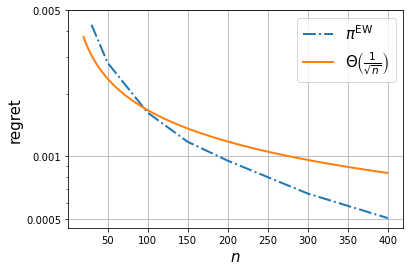

In [259]:
regret = np.array(EW_costs) - np.array(ideal_costs)
plt.plot(ns, regret, linestyle='-.', linewidth=2.0)
stds = np.array(stds)
plt.plot(range(20, 400), 1/np.sqrt(np.array(range(20,400)))/60, linewidth=2.0)

#plt.fill_between(ns, regret - stds, regret + stds,
#                 color='gray', alpha=0.2)
plt.yscale("log")
plt.xlabel(r'$n$', fontsize=15)
plt.ylabel(r'regret', fontsize=15)
plt.yticks([0.005, 0.001, 0.0005], [5*1e-3, 1e-3, 5*1e-4])
plt.grid()
plt.legend([r'$\pi^{\mathrm{EW}}$', r'$\Theta\left(\frac{1}{\sqrt{n}}\right)$'], fontsize=15)
plt.savefig('regret.eps', bbox_inches="tight")


In [ ]:
from data import input as input
from algorithms import algorithms as algorithms
from algorithms import utility as utility 
from model import anomaly as anomaly

In [6]:
data = input.DataInput()
data.synthetic_data(n1=100, n2=100, r =2, mean_value = 10, prob_observing = 1)
anomaly_model = anomaly.ExponentialAnomaly(p = 0.1, exp_rate = )
data.add_anomaly(anomaly_model)
data.cost_generation()

In [ ]:
def generate_data_for_table_cost(self, file_path = "", file_name = "", num_exper=200, r_range = [1, 10],
                                    mean_value_range = [1, 10], p_o_range = [0.5, 1], p_a_range = [0, 0.3], alpha_range = [0, 1], AD_only=False):
        
    c_opt = np.zeros(num_exper)
    c_EW = np.zeros(num_exper)
    c_stable_PCP = np.zeros(num_exper)
    c_DRMF = np.zeros(num_exper)
    c_RMC = np.zeros(num_exper)

    parameters = []

    start = 0
    n1 = 100
    n2 = 100
    for T in range(start, num_exper):
        r = np.random.randint(r_range[0], high=r_range[1]+1)
        mean_value = np.random.uniform(mean_value_range[0], mean_value_range[1])
        p_o = np.random.uniform(p_o_range[0], p_o_range[1])
        p_a = np.random.uniform(p_a_range[0], p_a_range[1])
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])

        data = input.DataInput()
        data.synthetic_data(n1=n1, n2=n2, r=r, mean_value = mean_value, prob_observing = p_o)
        anomaly_model = anomaly.ExponentialAnomaly(p = p_a, exp_rate = 1/alpha, p_range = (0.01, 0.5), one_over_exp_range=(0.01, 0.9))
        data.add_anomaly(anomaly_model)
        data.cost_generation()

        c_opt[T] = algorithms.ideal_cost(data)

        
        c_EW[T] = algorithms.EW_algorithm(data, gamma = n1/r*0.5, r_constraint = r, debug=False, do_SVD = False, cost_only = True)
        x = []
        c_DRMF[T] = np.min([algorithms.DRMF(data, r, rate, cost_only=True) for rate in [0.1, 0.3, 0.5]])
        if (not AD_only):
            c_stable_PCP[T] = self.Robust_PCA(gamma = (self.n2/r*0.5/2), r_constraint=self.r, cost_only=True)

            c_RMC[T] = self.Robust_PCA(gamma = (self.n2/r*0.5/2), r_constraint=self.r, up_M = np.max(self.M0)*12, up_A = np.max(self.M0)*12, cost_only=True)

        parameters.append((r, mean_value, p_o, p_a, alpha))

        print('In the step {}, c_opt is {}, c_EW is {}, c_stable_PCP is {}, c_DRMF is {}, c_RMC is {}'.format(T, c_opt[T], c_EW[T], c_stable_PCP[T], c_DRMF[T], c_RMC[T]))
        print('r is {}, mean is {}, p_o is {}, p_a is {}, alpha is {}'.format(r, mean_value, p_o, p_a, alpha))

    return parameters, c_opt, c_EW, c_DRMF, c
            # if (T % 10 == 0 or T == num_exper - 1):
            #     print('In the step {}, saving data...'.format(T))
            #     if not os.path.exists(file_path):
            #         os.makedirs(file_path)
            #     f = open(file_path+file_name, 'wb')
            #     np.save(f, parameters)
            #     np.save(f, c_opt)
            #     np.save(f, c_AD)
            #     np.save(f, c_DRMF)
            #     np.save(f, c_RMF)
            #     np.save(f, c_PCA)